# Tarea 1 <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas partes 1, 2, 3, 4 y 5
## Nombre: Martin Cornejo Saavedra
Fecha sugerida para completar esta parte: 23 de marzo de 2018

In [0]:
# instalacion de los paquetes necesarios

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q ipdb

import os
import glob
import torch
import numpy
import pdb
import matplotlib.pyplot as plt


# Parte 1: Funciones de activación, derivadas y función de salida

## 1a) Funciones de activación

In [0]:
def relu(T):
    T[T < 0] = 0
    return T

def sig(T):
    return torch.reciprocal(1 + torch.exp(-1 * T))

def swish(T, beta):
    return torch.mul(T, sig(torch.mul(T, beta)))

def celu(T, alfa):
    positive = relu(T)
    negative = torch.mul(relu(torch.mul(T, -1)), -1)
    celu_T = torch.mul(torch.add(torch.exp(torch.div(negative, alfa)), -1), alfa)

    return torch.add(positive, 1, celu_T)

## 1b) Derivando las funciones de activación


\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} =
\left\{
	\begin{array}{ll}
		1  & \mbox{si } x \geq 0 \\
		0  & \mbox{~} 
	\end{array}
\right. 
\end{equation}
<br>

Dado $ \sigma (x) = sigmoid(x)$, tenemos que:

\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = \sigma (\beta x) + \beta x \cdot \sigma (\beta x)(1-\sigma (\beta x)) \\
& = \sigma (\beta x) + \beta x \cdot \sigma (\beta x) - \beta x \cdot \sigma (\beta x)^{2}  \\
&= \beta \cdot swish(x, \beta) + \sigma (\beta x)(1 - \beta \cdot swish(x, \beta))\\
\\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & =  
x^2 \sigma (\beta x)(1 - \sigma (\beta x))\\
\end{eqnarray}
<br><br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & =  
\left\{
	\begin{array}{ll}
		1  & \mbox{si } x \geq 0 \\
		exp (\frac{x}{\alpha})  & \mbox{~} 
	\end{array}
\right. \\
\\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = 
\left\{
	\begin{array}{ll}
		0  & \mbox{si } x \geq 0 \\
		exp (\frac{x}{\alpha})(1 - \frac{x}{\alpha}) - 1  & \mbox{~} 
	\end{array}
\right. \\
\end{eqnarray}

## 1c) Softmax

Dada la funcion `softmax` sabemos que cada elemento de la secuencia $\text{softmax}(x_1,\ldots,x_n)$ tiene la forma

\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}

Luego, para cada elemento de la secuencia $\text{softmax}(x_1-M,\ldots,x_n-M)$ se tiene

\begin{equation}
s_i = \frac{e^{x_i-M}}{\sum_{j=1}^{n}e^{x_j-M}} = \frac{e^{-M}e^{x_i}}{\sum_{j=1}^{n}e^{-M}e^{x_j}} = \frac{e^{-M}e^{x_i}}{e^{-M}\sum_{j=1}^{n}e^{x_j}} = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}

Demostrando que $\text{softmax}(x_1-M,\ldots,x_n-M) = \text{softmax}(x_1,\ldots,x_n)$.

In [0]:
# por ahora softmax estara implementada solo para tensores en 2-D
def softmax(T, dim=0, estable=True):
    denom_softmax = torch.div(T, 2)
    denom_softmax = torch.exp(denom_softmax)
    denom_softmax = torch.mm(denom_softmax, torch.transpose(denom_softmax, 0, 1))
    denom_softmax = torch.reciprocal(torch.diag(denom_softmax))

    return torch.mm(torch.diag(denom_softmax), T.exp())

# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Usando la GPU, 2c) Pasada hacia adelante

In [0]:
class FFNN():
    def __init__(self, F, l_h, l_a, C, params=[]):
      if (len(params) > 0):
        self.W_1 = params[0][0]
        self.b_1 = params[0][1]
        self.W_2 = params[1][0]
        self.b_2 = params[1][1]
        self.U = params[2][0]
        self.c_init = params[2][1]
        self.l_a = l_a

      else:
        self.F = F
        self.l_h = l_h
        self.l_a = l_a
        self.C = C

        self.W_1 = torch.randn(F, l_h[0])
        self.b_1 = torch.zeros(1, l_h[0])

        self.W_2 = torch.randn(l_h[0], l_h[1])
        self.b_2 = torch.zeros(1, l_h[1])

        self.U = torch.randn(l_h[1], C)
        self.c_init = torch.zeros(1, C)
          
  
    def gpu(self):
      if torch.cuda.is_available():
        self.W_1 = self.W_1.cuda()
        self.b_1 = self.b_1.cuda()
        self.W_2 = self.W_2.cuda()
        self.b_2 = self.b_2.cuda()
        self.U = self.U.cuda()
        self.c_init = self.c_init.cuda()
  
    def cpu(self):
      self.W_1 = self.W_1.cpu()
      self.b_1 = self.b_1.cpu()
      self.W_2 = self.W_2.cpu()
      self.b_2 = self.b_2.cpu()
      self.U = self.U.cpu()
      self.c_init = self.c_init.cpu()
  
    def forward(self, x):
      if torch.cuda.is_available():
        x = x.cuda()
        self.gpu()   # redundante, corregir
      
      h_1 = self.l_a[0](torch.mm(x, self.W_1) + self.b_1)
      h_2 = self.l_a[1](torch.mm(h_1, self.W_2) + self.b_2)
      y = softmax(torch.mm(h_2, self.U) + self.c_init)

      return y

## 2d) Probando tu red con un modelo pre-entrenado

In [370]:
## Clonamos el github

!git clone https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile.git

os.chdir("/content/cc6204-DeepLearning-DCCUChile/2018/tareas/tarea1/recursos/varita_magica")

fatal: destination path 'cc6204-DeepLearning-DCCUChile' already exists and is not an empty directory.


In [371]:
# cargar parametros entrenados a tensores

local_download_path = "modelos/ejemplo"
params = []
params.append([numpy.loadtxt(local_download_path+"/W1.txt"), numpy.loadtxt(local_download_path+"/b1.txt")])
params.append([numpy.loadtxt(local_download_path+"/W2.txt"), numpy.loadtxt(local_download_path+"/b2.txt")])
params.append([numpy.loadtxt(local_download_path+"/U.txt"), numpy.loadtxt(local_download_path+"/c.txt")])

params = list(map(lambda x: [torch.from_numpy(x[0]), torch.from_numpy(x[1])], params))
#pdb.set_trace()


# cargar red neuronal en pase a parametros conocidos

test_data_path = "data/test_set"
test_input = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-7/019.txt")).double().cuda().view(1, 4096)
red_neuronal = FFNN(0, [], [sig, sig], 10, params)
red_neuronal.forward(test_input)



Columns 0 to 5 
 4.7710e-02  3.9716e-05  6.6476e-04  8.2011e-10  4.3855e-05  5.6656e-06

Columns 6 to 9 
 3.6484e-06  1.4471e-04  9.5139e-01  3.8229e-08
[torch.cuda.DoubleTensor of size 1x10 (GPU 0)]

## Ejemplos erroneos

El siguiente hechizo pertenece a la clase 9 pero fue clasificado como clase 1:


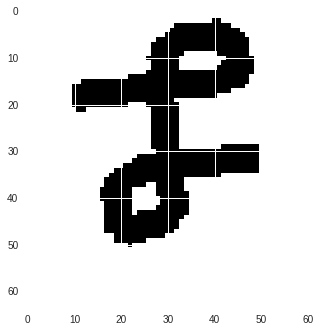

El siguiente hechizo pertenece a la clase 7 pero fue clasificado como clase 8:


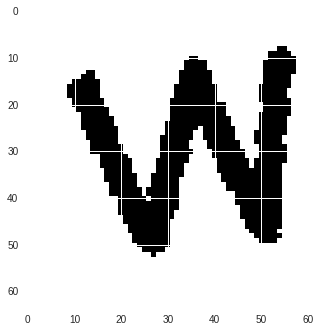

In [372]:
test_input_err_1 = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-9/019.txt")).double().cuda().view(64, 64)
plt.imshow(test_input_err_1)
print("El siguiente hechizo pertenece a la clase 9 pero fue clasificado como clase 1:")
plt.show()
test_input_err_2 = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-7/019.txt")).double().cuda().view(64, 64)
plt.imshow(test_input_err_2)
print("El siguiente hechizo pertenece a la clase 7 pero fue clasificado como clase 8:")

# Parte 3: Más derivadas y back propagation

## 3a) Entropía Cruzada

In [0]:
def cross_ent_loss(Q,P):
    dimension = 0
    q_log = torch.log(Q)
    product = torch.mul(P, torch.reciprocal(q_log))

    return -torch.sum(product)/Q.size(dimension)

## 3b) Derivando la última capa

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L)}} = \frac{\partial \cal L}{\partial ŷ} \cdot \frac{\partial ŷ}{\partial u^{(L)}} \\
\end{equation}

In [0]:
B = 5; C = 10

y = torch.ones(B,C)
y_pred = torch.ones(B,C)

# Acá tu trozo de código. 
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas

dimL = 15

hL = torch.ones(B,dimL)
U = torch.ones(dimL,C)
c_bias = torch.ones(C)

uL = hL.mm(U).add(c_bias)

# Notamos que por regla de la cadena, 
# dL_duL = dL_dypred * dypred_duL
# el primer termino de la derecha es la derivada
# de cross entropy 
# el segundo termino de la derecha es la derivada de softmax

dL_duL = torch.mul(torch.mul(y, torch.add(y_pred, -1)), 1/y_pred.size(0))

# El gradiente debe coincidir en dimensiones con la variable

assert dL_duL.size() == uL.size()

## 3b) Derivando la última capa (continuación)

Usando la notación de Einstein tenemos que:

\begin{eqnarray}
(\frac{\partial\cal L}{\partial U})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} \frac{\partial u^{(L)}_{kl}}{\partial U_{ij}} \\
\end{eqnarray}

Luego,

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial U_{ij}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial U_{ij}} = \left\{
    \begin{array}{}
		h^{(L)}_{ki}  & \mbox{si } r = i,\ l = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

Entonces,

\begin{eqnarray}
(\frac{\partial\cal L}{\partial U})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} h^{(L)}_{ki} = \frac{\partial\cal L}{\partial u^{(L)}_{kj}} h^{(L)}_{ki} \\
\\
& \boxed{ \frac{\partial\cal L}{\partial U} = (h^{(L)})^{T} \frac{\partial\cal L}{\partial u^{(L)}} }
\end{eqnarray}

Análogamente

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial c_{i}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial c_{i}} = \left\{
    \begin{array}{}
		1  & \mbox{si } l = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

\begin{eqnarray}
(\frac{\partial\cal L}{\partial c})_{i} &= \frac{\partial\cal L}{\partial u^{(L)}_{ki}} \cdot 1
\end{eqnarray}

\begin{equation}
\boxed{ \frac{\partial\cal L}{\partial c} = [1 \ldots 1] \frac{\partial\cal L}{\partial u^{(L)}} }
\end{equation}

Donde $[1 \ldots 1]$ es un vector de unos de largo correspondiente al numero de fila del resultado de $\frac{\partial\cal L}{\partial u^{(L)}}$ 

Finalmente,

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial h^{(L)}_{ij}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial h^{(L)}_{ij}} = \left\{
    \begin{array}{}
		U_{jl}  & \mbox{si } k = i,\ r = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

\begin{eqnarray}
(\frac{\partial\cal L}{\partial h^{(L)}})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} U_{jl} = \frac{\partial\cal L}{\partial u^{(L)}_{il}} U_{lj}^{T} \\
\\
& \boxed{ \frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial\cal L}{\partial u^{(L)}} U^{T} }
\end{eqnarray}

In [0]:
dL_dU = torch.mm(torch.transpose(hL, 0, 1), dL_duL)

dL_dc = torch.mm(torch.ones(1, dL_duL.size(0)), dL_duL)

dL_dhL = torch.mm(dL_duL, torch.transpose(U, 0, 1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_dU.size() == U.size()
assert dL_dc.size(1) == c_bias.size(0)
assert dL_dhL.size() == hL.size()

## 3c) Derivando desde las capas escondidas

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} \frac{\partial\cal h^{(k)}}{\partial u^{(k)}} \\
\end{equation}

Para __sigmoid__ tenemos la siguiente derivada:
\begin{equation}
h^{(k)} = sig(u^{(k)})
\\
\frac{\partial\cal h^{(k)}}{\partial u^{(k)}} = h^{(k)}(1 - h^{(k)})
\end{equation}
<br><br>

Las siguientes derivadas pueden obtenerse independiente de la forma de la función de activación y son análogas a las calculadas en la última capa:
<br><br>
\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = (h^{(k)})^{T} \frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = [1 \ldots 1] \frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} (W^{(k)})^T \\
\end{equation}

In [0]:
# Acá tu trozo de código. 
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas

dimk = 20
dimkm1 = 15

hk = torch.ones(B,dimk)
Wk = torch.ones(dimk,dimkm1)
bk = torch.ones(dimkm1)

uk = hk.mm(Wk).add(bk)

dL_dhkm1 = torch.ones(B,dimkm1)

# Ahora tu fórmula para el gradiente.
# Esto debes repetirlo para relu, celu, y swish

# para sigmoid
dL_duk_sig = torch.mul(dL_dhkm1, torch.mul(hL, torch.mul(torch.add(hL, -1), -1)))

# para relu
dL_duk_rel = None

# para celu
dL_duk_celu = None

# para swish
dL_duk_swish = None

# se elige una funcion de activacion
dL_duk = dL_duk_sig

# estas derivadas se calculan de la misma forma para cualquier funcion de activacion

dL_dWk = torch.mm(torch.transpose(hk, 0, 1), dL_duk)
dL_dbk = torch.mm(torch.ones(1, dL_duk.size(0)), dL_duk)
dL_dhk = torch.mm(dL_duk, torch.transpose(Wk, 0, 1))

# El gradiente debe coincidir en dimensiones con las variables

assert dL_duk.size() == uk.size()
assert dL_dWk.size() == Wk.size()
assert dL_dbk.size(1) == bk.size(0)
assert dL_dhk.size() == hk.size()

# Parte 4: Backpropagation en nuestra red

## 4a) Método `backward`

In [0]:
class FFNN():
    def __init__(self, F, l_h, l_a, C, params=[]):
      if (len(params) > 0):
        self.W_1 = params[0][0]
        self.b_1 = params[0][1]
        self.W_2 = params[1][0]
        self.b_2 = params[1][1]
        self.U = params[2][0]
        self.c_init = params[2][1]
        
        self.c_init = self.c_init.view(1, self.c_init.size(0))
        self.b_2 = self.b_2.view(1, self.b_2.size(0))
        self.b_1 = self.b_1.view(1, self.b_1.size(0))
        
        self.l_a = l_a

      else:
        self.F = F
        self.l_h = l_h
        self.l_a = l_a
        self.C = C

        self.W_1 = torch.randn(F, l_h[0])
        self.b_1 = torch.zeros(1, l_h[0])

        self.W_2 = torch.randn(l_h[0], l_h[1])
        self.b_2 = torch.zeros(1, l_h[1])

        self.U = torch.randn(l_h[1], C)
        self.c_init = torch.zeros(1, C)
          
  
    def gpu(self):
      if torch.cuda.is_available():
        self.W_1 = self.W_1.double().cuda()
        self.b_1 = self.b_1.double().cuda()
        self.W_2 = self.W_2.double().cuda()
        self.b_2 = self.b_2.double().cuda()
        self.U = self.U.double().cuda()
        self.c_init = self.c_init.double().cuda()
  
    def cpu(self):
      self.W_1 = self.W_1.cpu()
      self.b_1 = self.b_1.cpu()
      self.W_2 = self.W_2.cpu()
      self.b_2 = self.b_2.cpu()
      self.U = self.U.cpu()
      self.c_init = self.c_init.cpu()
  
    def forward(self, x):
      if torch.cuda.is_available():
        x = x.double().cuda()
        self.gpu()   # redundante, corregir
      
      #pdb.set_trace()
      self.h_1 = self.l_a[0](torch.mm(x, self.W_1) + self.b_1)
      self.h_2 = self.l_a[1](torch.mm(self.h_1, self.W_2) + self.b_2)
      y = softmax(torch.mm(self.h_2, self.U) + self.c_init)

      return y
  
    def backward(self, x, y, y_pred):
      
      gradientes = {}
      
      # gradientes capa de salida
      
      dimL = self.b_2.size(0)
      uL = self.h_2.mm(self.U).add(self.c_init)
      
      #dL_duL = torch.mul(torch.mul(y, torch.add(y_pred, -1)), 1/y_pred.size(0))
      dL_duL = torch.mul(torch.add(y_pred, torch.mul(y, -1)), 1/y_pred.size(0))
      dL_dU = torch.mm(torch.transpose(self.h_2, 0, 1), dL_duL)
      dL_dc = torch.mm(torch.ones(1, dL_duL.size(0)).double().cuda(), dL_duL)
      dL_dh2 = torch.mm(dL_duL, torch.transpose(self.U, 0, 1))
      
      assert dL_duL.size() == uL.size()
      assert dL_dU.size() == self.U.size()
      
      #pdb.set_trace()
      
      assert dL_dc.size(1) == self.c_init.size(1)
      assert dL_dh2.size() == self.h_2.size()

      # gradientes segunda capa escondida
      
      u2 = self.h_1.mm(self.W_2).add(self.b_2)  

      # para sigmoid
      dL_du2_sig = torch.mul(dL_dh2, torch.mul(self.h_2, torch.mul(torch.add(self.h_2, -1), -1)))
  
      # para relu
      dL_duk_rel = None

      # para celu
      dL_duk_celu = None

      # para swish
      dL_duk_swish = None

      # se elige una funcion de activacion
      dL_du2 = dL_du2_sig

      dL_dW2 = torch.mm(torch.transpose(self.h_1, 0, 1), dL_du2)
      dL_db2 = torch.mm(torch.ones(1, dL_du2.size(0)).double().cuda(), dL_du2)
      dL_dh1 = torch.mm(dL_du2, torch.transpose(self.W_2, 0, 1))

      assert dL_du2.size() == u2.size()
      assert dL_dW2.size() == self.W_2.size()
      assert dL_db2.size(1) == self.b_2.size(1)
      assert dL_dh1.size() == self.h_1.size()
      
      # gradientes primera capa escondida
      
      u1 = x.mm(self.W_1).add(self.b_1)  

      # para sigmoid
      dL_du1_sig = torch.mul(dL_dh1, torch.mul(self.h_1, torch.mul(torch.add(self.h_1, -1), -1)))
  
      # para relu
      dL_duk_rel = None

      # para celu
      dL_duk_celu = None

      # para swish
      dL_duk_swish = None

      dL_du1 = dL_du1_sig

      dL_dW1 = torch.mm(torch.transpose(x, 0, 1), dL_du1)
      dL_db1 = torch.mm(torch.ones(1, dL_du1.size(0)).double().cuda(), dL_du1)
      dL_dx = torch.mm(dL_du1, torch.transpose(self.W_1, 0, 1))

      assert dL_du1.size() == u1.size()
      assert dL_dW1.size() == self.W_1.size()
      assert dL_db1.size(1) == self.b_1.size(1)
      assert dL_dx.size() == x.size()
      
      for gradiente in ['dL_db1', 'dL_dW1', 'dL_db2', 'dL_dW2', 'dL_dc', 'dL_dU']:
        gradientes[gradiente] = eval(gradiente)
      
      self.gradientes = gradientes
    
    def actualizarParams(self, lr):
      self.W_1 = self.W_1 - lr * self.gradientes['dL_dW1']
      self.b_1 = self.b_1 - lr * self.gradientes['dL_db1']

      self.W_2 = self.W_2 - lr * self.gradientes['dL_dW2']
      self.b_2 = self.b_2 - lr * self.gradientes['dL_db2']

      self.U = self.U - lr * self.gradientes['dL_dU']
      self.c_init = self.c_init - lr * self.gradientes['dL_dc']

## 4b) Checkeo de gradiente

# Parte 5: Descenso de gradiente y entrenamiento

## 5a) Descenso de gradiente (estocástico)

In [0]:
class SGD():
  def __init__(self, red, lr):
    self.red = red
    self.lr = lr
  
  def step(self):
    self.red.actualizarParams(self.lr)

## 5b) Datos para carga

In [0]:
class RandomDataset():
  def __init__(self, N, F, C):
    x = torch.rand(N, F)
    self.x = torch.bernoulli(x).double().cuda()
    self.y = torch.from_numpy(numpy.eye(C)[numpy.random.choice(C, N)]).double().cuda()
    self.large = N
  
  def __len__(self):
    return self.large
  
  def __getitem__(self, i):
    return (self.x[i,:], self.y[i,:])
  
  def paquetes(self, B):
       
    if not hasattr(self, 'arr_paquetes'):
      n_iters = int(self.x.size(0)/B)
      arr_paquetes = []  
   
      for index in range(n_iters):
        arr_paquetes.append(self.elige_batch(self.x,self.y,B))
              
      self.arr_paquetes = arr_paquetes
      
    return self.arr_paquetes
    
  # Para elegir el siguiente batch (uno al azar) desde los datos de entrada
  def elige_batch(self, X, Y, b):
    N = X.size()[0]
    x_lista = []
    y_lista = []
  
    for _ in range(b):
      i = numpy.random.randint(N)
      x_lista.append(X[i:i+1])
      y_lista.append(Y[i:i+1])      
  
    x = torch.cat(x_lista, dim=0)
    y = torch.cat(y_lista, dim=0)
    #pdb.set_trace()
  
    return x,y

## 5c) Entrenando la red

In [0]:
def entrenar_FFNN(red_neuronal, dataset, optimizador, epochs, B):
  
  perdidas = []
  
  for e in range(1,epochs+1):
    for x,y in dataset.paquetes(B):
      y_pred = red_neuronal.forward(x)
      #pdb.set_trace()
      perdidas.append(cross_ent_loss(y_pred,y))
      
      red_neuronal.backward(x, y, y_pred)
      optimizador.step()  
    
  return red_neuronal, perdidas  

## 5d) Graficando la pérdida en el tiempo

True

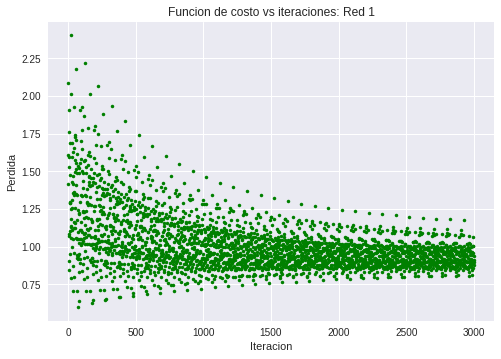

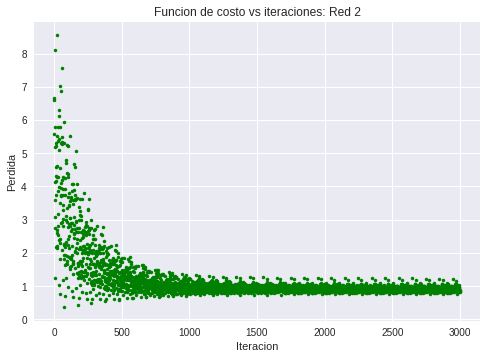

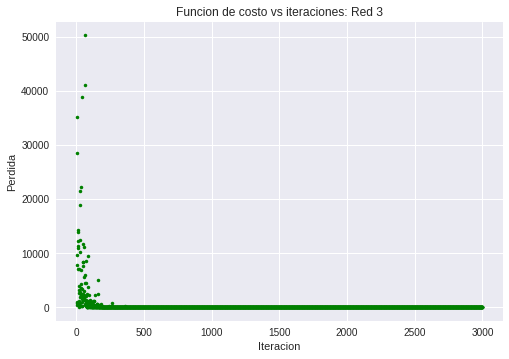

In [381]:
#red_entrenada, perdida = entrenar_FFNN(red, dataset, optimizador, 20, 4)

#red_neuronal = FFNN(0, [], ['algo'], 10, params)
import matplotlib.pyplot as plt
features = 10
clases = 3
dataset = RandomDataset(1000,features,clases)

redes = [
    FFNN(features, [5, 5], [sig, sig], clases),
    FFNN(features, [15, 15], [sig, sig], clases),
    FFNN(features, [50, 50], [sig, sig], clases)
]

for idx, red_neuronal in enumerate(redes):

  red_neuronal.gpu()

  optimizador = SGD(red_neuronal, 0.001) 

  epochs = 30
  batch = 10
  red_neuronal, perdidas = entrenar_FFNN(red_neuronal, dataset, optimizador, epochs, batch)

  plt.figure()
  plt.plot(numpy.linspace(1, len(perdidas), len(perdidas)), perdidas, 'g.')
  plt.title("Funcion de costo vs iteraciones: Red "+str(idx+1))
  plt.xlabel("Iteracion")
  plt.ylabel("Perdida")
  #pdb.set_trace()
  
True